# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


In [1]:
student1_id = '327156998'
student2_id = '311451660'

**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [2]:
# %pip install --q
# %pip install --q transformers
# %pip install -U sentence-transformers

All imports: (You may add/change)

In [3]:
# general
import os
import random
import warnings
from typing import List,Tuple
import pickle
import re

# ML
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display


# DL
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoModel
from sentence_transformers import SentenceTransformer


Set warnings filter to ignore:

In [4]:
# set warnings filter to ignore:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [5]:
# set random SEEDs:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Set GPU:

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')

Using cuda device


## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [7]:
# !git clone https://github.com/kfirbar/nlp-course

## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [8]:
def read_data(filepath: str, remove_e1_e2_from_label: bool = True) -> List[Tuple[str, str]]:
    """ Read the data from the file and return a list of tuples (sentence, label)
        args:
            filepath: the path to the file
            remove_e1_e2_from_label: if True, remove the (e1,e2) from the label
        return:
            data: a list of tuples (sentence, label)
    """
    data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 4): # 4 lines per sample
            # get the sentence between the quotes
            sentence = re.findall(r'"([^"]*)"', lines[i])[0]
            # get the label from the next line
            label = lines[i+1].strip()
            # remove (e1,e2) from label
            if remove_e1_e2_from_label:
                label = label.replace('(e1,e2)', '').replace('(e2,e1)', '').strip()
            data.append((sentence, label))
    return data



In [9]:
# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"

# Read the data into lists of tuples (sentence, label)
train = read_data(train_filepath)
test = read_data(test_filepath)

# Create a dataframe from the data
train_df = pd.DataFrame(train, columns=['sentence', 'label'])
test_df = pd.DataFrame(test, columns=['sentence', 'label'])

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


In [10]:
# print first 5 samples from train and test
print('Train samples:')
display(train_df.head())
print('Test samples:')
display(test_df.head())


Train samples:


,sentence,label
0,The system as described above has its greatest...,Component-Whole
1,The <e1>child</e1> was carefully wrapped and b...,Other
2,The <e1>author</e1> of a keygen uses a <e2>dis...,Instrument-Agency
3,A misty <e1>ridge</e1> uprises from the <e2>su...,Other
4,The <e1>student</e1> <e2>association</e2> is t...,Member-Collection


Test samples:


,sentence,label
0,The most common <e1>audits</e1> were about <e2...,Message-Topic
1,The <e1>company</e1> fabricates plastic <e2>ch...,Product-Producer
2,The school <e1>master</e1> teaches the lesson ...,Instrument-Agency
3,The suspect dumped the dead <e1>body</e1> into...,Entity-Destination
4,Avian <e1>influenza</e1> is an infectious dise...,Cause-Effect


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [11]:
# given a dataframe, return a dictionary mapping each label to its id and vice versa
def create_label_mapper(data_df):
  ""
  id2label = {}
  label2id = {}
  unique_labels = data_df['label'].unique()
  for i, label in enumerate(unique_labels):
    id2label[i] = label
    label2id[label] = i
  return id2label, label2id



id2label, label2id = create_label_mapper(train_df)

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

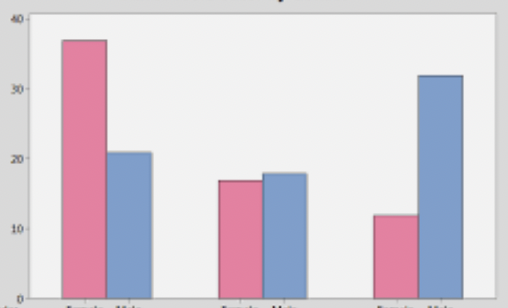

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

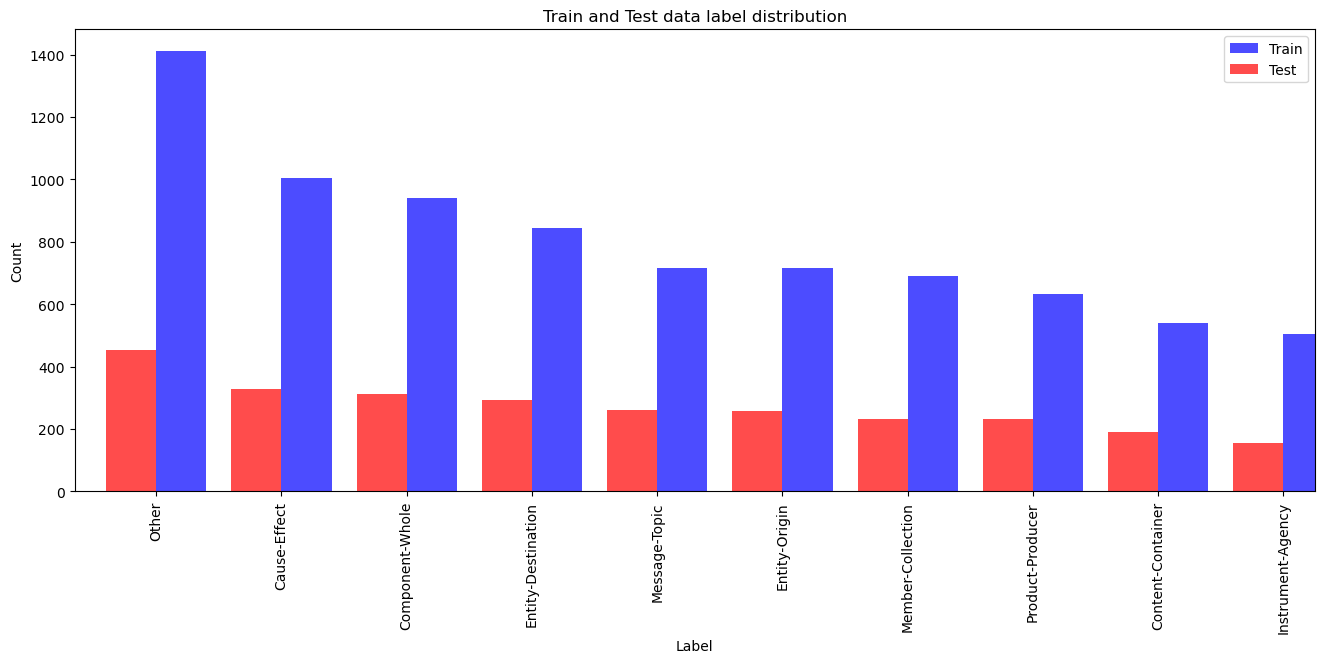

In [12]:
# plot the label distribution in the train and test datasets
def plot_label_distribution(train_data, test_data, title):
    # make a copy of the data so we won't change the original dataframe
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    # create a figure and axis object
    fig, ax = plt.subplots(figsize=(16, 6))
    # plot the count of each label in the train and test dataset
    train_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Train', position=0, width=0.4)
    test_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='red', alpha=0.7, label='Test', position=1, width=0.4)

    # set the x and y axis labels and title
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(title)
    # plot the legend and show the plot
    ax.legend() 
    plt.show()
    # return the unique labels in the train
    return train_data_copy['label'].unique()
    
# call the function to plot the label distribution in the train and test datasets
train_labels = plot_label_distribution(train_df, test_df, 'Train and Test data label distribution')


<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [14]:
def prepare_data(data, tokenizer, label2id=label2id):
    """ Tokenize the data and map the labels to their ids
        args:
            data: a list of tuples (sentence, label)
            tokenizer: a tokenizer object
        return:
            data_sequences: a list of tuples (tokenized sentence, label id)
    """
    data_sequences = [(tokenizer.encode(sentence), label2id[label]) for sentence, label in data]
    return data_sequences

train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

train_sequences_df = pd.DataFrame(train_sequences, columns=['tokens', 'label_id'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['tokens', 'label_id'])

In [15]:
# print some examples
print('Train examples:')
display(train_sequences_df.sample(5))
print('Test examples:')
display(test_sequences_df.sample(5))

Train examples:


,tokens,label_id
879,"[101, 1999, 1996, 3944, 1010, 2002, 4711, 1026...",5
5183,"[101, 7297, 1010, 1996, 2556, 11028, 2950, 103...",1
3143,"[101, 1996, 5080, 2003, 1996, 2190, 5576, 2005...",0
2967,"[101, 1996, 13541, 1026, 1041, 2487, 1028, 138...",9
2,"[101, 1996, 1026, 1041, 2487, 1028, 3166, 1026...",2


Test examples:


,tokens,label_id
1740,"[101, 1996, 14070, 1026, 1041, 2487, 1028, 249...",1
1333,"[101, 2178, 2307, 3696, 2001, 1996, 6919, 2395...",6
2196,"[101, 9690, 1010, 2111, 1999, 1996, 1026, 1041...",8
744,"[101, 2116, 1026, 1041, 2487, 1028, 3471, 1026...",4
2602,"[101, 8811, 3859, 2077, 1996, 4028, 1010, 1037...",1


In [16]:
# Convert the sequences to PyTorch tensors
train_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df['label_id'].tolist())
)

test_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df['label_id'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = data_utils.random_split(train_dataset, [train_size, val_size])

# create the dataloaders
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [17]:
# test the dataloaders
for batch in train_dataloader:
    input_ids, labels = batch
    print('Input IDs shape:', input_ids.shape)
    print('Labels shape:', labels.shape)
    break


Input IDs shape: torch.Size([16, 141])
Labels shape: torch.Size([16])


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [18]:
model_part3 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(id2label)).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [19]:
# # print model layers
# print('Model layers:')
# for name, param in model_part3.named_parameters():
#     print(f'{name} has shape {param.shape}')


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [20]:
def get_layer_parameters(named_params, layer_names):
    # return the parameters of the layers whose names contain any of the strings in layer_names
    layer_params = [param for name, param in named_params if any(layer_name in name for layer_name in layer_names)]
    return layer_params

layer_names = ['classifier', 'pooler', 'layer.11'] # the names of the layers we want to fine-tune
all_model_params = model_part3.named_parameters() # all the model parameters
top_layer_params = get_layer_parameters(all_model_params, layer_names)


In [21]:
# set requires_grad to False for all parameters except the top layer
for name, param in model_part3.named_parameters():
    if any(layer_name in name for layer_name in layer_names):
        param.requires_grad = True
    else:
        param.requires_grad = False

print('Parameters that will be fine-tuned:')
for name, param in model_part3.named_parameters():
    if param.requires_grad:
        print(name)

Parameters that will be fine-tuned:
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias


Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [22]:
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [23]:
# train the model for 1 epoch, return the average loss and accuracy
def single_train_part4(model, optimizer, criterion, train_dataloader):
    model.train() # set the model to training mode
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad() # zero the gradients
        sentences, labels = batch
        sentences = sentences.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model.forward(sentences) # forward pass
        loss = criterion(outputs.logits, labels) # calculate the loss
        loss.backward() # backward pass
        optimizer.step() # update the weights
        _, preds = torch.max(outputs.logits, dim=1) # get the predicted labels
        acc = torch.sum(preds == labels).item() # calculate the accuracy
        train_loss += loss.item()
        train_acc += acc
    train_loss = train_loss / len(train_dataloader) # calculate the average loss
    train_acc = train_acc / len(train_dataloader.dataset) # calculate the average accuracy
    return train_loss, train_acc


# evaluate the model on the dev set, return the average loss and accuracy
def evaluate_part4(model, criterion, dev_dataloader):
    model.eval() # set the model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for batch in dev_dataloader:
            sentences, labels = batch
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model.forward(sentences) # forward pass
            loss = criterion(outputs.logits, labels) # calculate the loss
            _, preds = torch.max(outputs.logits, dim=1) # get the predicted labels
            acc = torch.sum(preds == labels).item() # calculate the accuracy
            val_loss += loss.item()
            val_acc += acc
    val_loss = val_loss / len(dev_dataloader) # calculate the average loss
    val_acc = val_acc / len(dev_dataloader.dataset) # calculate the average accuracy
    return val_loss, val_acc


# train the model for n_epochs, return the history of train loss, val loss, train acc, val acc
def full_train_part4(model, n_epochs, train_dataloader, dev_dataloader, optimizer, criterion):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    for epoch in tqdm(range(n_epochs)): # iterate over the epochs
        # train the model for one epoch
        train_loss, train_acc = single_train_part4(model, optimizer, criterion, train_dataloader)
        # evaluate the model on the dev set
        val_loss, val_acc = evaluate_part4(model, criterion, dev_dataloader)
        # save the loss and accuracy history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # print the loss and accuracy for this epoch
        print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(
            epoch + 1, n_epochs, train_loss, val_loss, train_acc, val_acc))
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [24]:
# train the model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = full_train_part4(model_part3, 20, train_dataloader, val_dataloader, optimizer, loss_fn)

# save the model and the history
torch.save(model_part3.state_dict(), 'model_part_4.pth')
torch.save({
    'train_loss_history': train_loss_history,
    'val_loss_history': val_loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history
}, 'model_part_4_history.pth')


  5%|▌         | 1/20 [00:43<13:52, 43.84s/it]

Epoch: 1/20, Train Loss: 1.6699, Val Loss: 0.8606, Train Acc: 0.3975, Val Acc: 0.7113


In [ ]:
# load the model and the history
model_part3.load_state_dict(torch.load('model_part_4.pth'))

history = torch.load('model_part_4_history.pth')
train_loss_history = history['train_loss_history']
val_loss_history = history['val_loss_history']
train_acc_history = history['train_acc_history']
val_acc_history = history['val_acc_history']

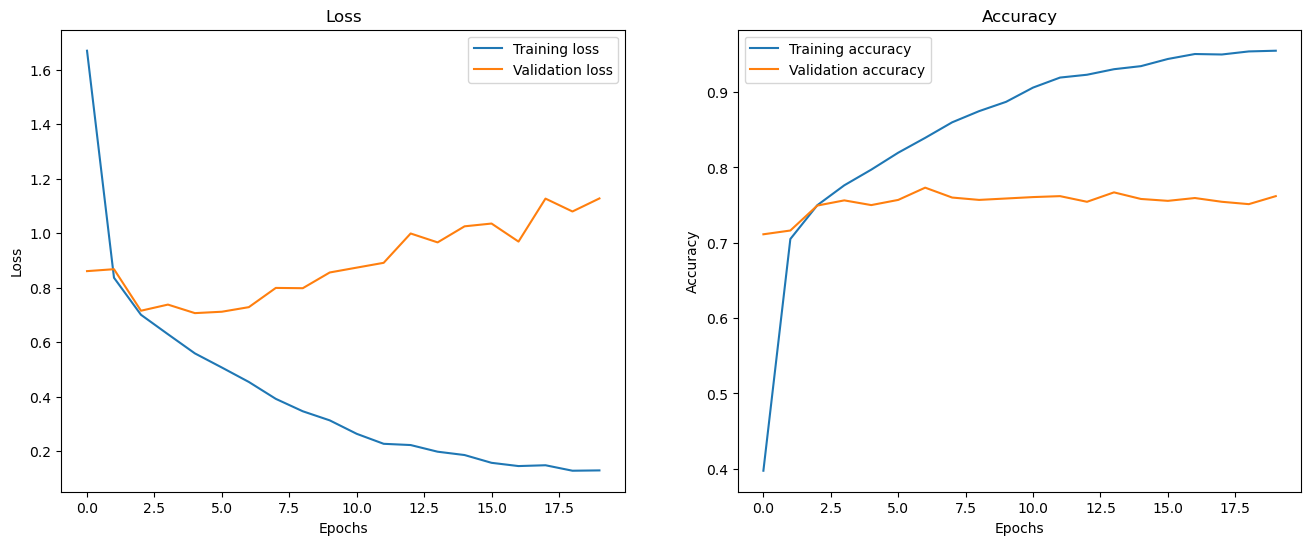

In [ ]:

# plot the training and validation loss
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(train_loss_history, label='Training loss')
axs[0].plot(val_loss_history, label='Validation loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the training and validation accuracy
axs[1].plot(train_acc_history, label='Training accuracy')
axs[1].plot(val_acc_history, label='Validation accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()



<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [ ]:

# given model and test data, return Report (Persicion, Recall, F1, Support) and Confusion Matrix
def predict_dataloader(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad(): # disable gradient calculation
    for batch in test_dataloader:
      sentences, labels = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model.forward(sentences) # forward pass
      _, preds = torch.max(outputs.logits, dim=1) # get the predicted labels
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   


# get the predictions and the true labels for the test set
y_pred , y_true = predict_dataloader(model_part3, test_dataloader)


In [ ]:
def get_report(y_pred, y_true, labels):
  report = classification_report(y_true, y_pred, output_dict=True, labels=labels)
  report = pd.DataFrame(report).transpose()
  report = report.loc[labels][['precision', 'recall', 'f1-score']]
  return report

def get_cm_matrix(y_pred, y_true, labels):
  matrix = confusion_matrix(y_true, y_pred, labels=labels)
  matrix = pd.DataFrame(matrix, index=labels, columns=labels).transpose() # rows are predicted, columns are actual
  return matrix

In [ ]:
# convert the label_ids to labels_str
y_pred_str = [id2label[i] for i in y_pred]
y_true_str = [id2label[i] for i in y_true]

# compute confusion matrix and classification report
cm_matrix = get_cm_matrix(y_pred_str, y_true_str, list(label2id.keys()))
report = get_report(y_pred_str, y_true_str, list(label2id.keys()))

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_matrix, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()
# print the classification report
print(tabulate(report, headers='keys', tablefmt='psql'))


In [ ]:
# compute the accuracy and print it
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print('test accuracy: ', accuracy)

In [ ]:
# save the report
name_to_save = student1_id + '_' + student2_id + '_part5.csv'
report.to_csv(name_to_save)

<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

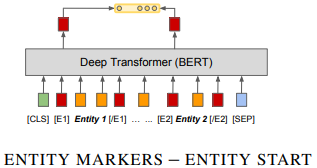

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

# add the new tokens to the tokenizer
new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_tokens(new_tokens)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"

# Read the data (tuple of (sentence, label)
train_with_entity_markers = read_data(train_filepath, remove_e1_e2_from_label=True)
test_with_entity_markers = read_data(test_filepath, remove_e1_e2_from_label=True)

# Convert to pandas dataframe
train_df_with_entity_markers = pd.DataFrame(train_with_entity_markers, columns=['sentence', 'label'])
test_df_with_entity_markers = pd.DataFrame(test_with_entity_markers, columns=['sentence', 'label'])

print('Number of train sentences:', len(train_with_entity_markers))
print('Number of test sentences:', len(test_with_entity_markers))

In [ ]:
id2label_with_entity_markers, label2id_with_entity_markers = create_label_mapper(train_df_with_entity_markers)
print('label2id:', label2id_with_entity_markers)
print('id2label:', id2label_with_entity_markers)

In [ ]:
# plot label distribution
plt.figure(figsize=(16, 6))
sns.countplot(x='label', data=train_df_with_entity_markers)
plt.title('Label Distribution')
plt.xticks(rotation=90) # rotate x-axis labels by 90 degrees
plt.show()

In [ ]:
# given a dataframe with sentence and label columns, returns a list of tuples (token_ids, label_id, index-tuple) s.t index-tuple = (e1_start, e1_end, e2_start, e2_end)
def prepare_data_MTB(data_df, tokenizer, batch_size=8):
    count = 0 # count the number of sentences that don't have the entity markers
    total = len(data_df)
    sequences = []
    # iterate over the data (dataframe with columns: sentence, label)
    for index, row in data_df.iterrows():
        sentence = row['sentence']
        label = row['label']
        # tokenize the sentence
        tokens = tokenizer.tokenize(sentence)
        # find the index of the entity markers
        if E1_START in tokens and E1_END in tokens and E2_START in tokens and E2_END in tokens:
            e1_start = tokens.index(E1_START)
            e1_end = tokens.index(E1_END)
            e2_start = tokens.index(E2_START)
            e2_end = tokens.index(E2_END)
            # convert the labels to label_ids
            label_id = label2id_with_entity_markers[label]
            # convert the tokens to token_ids
            token_ids = tokenizer.convert_tokens_to_ids(tokens)
            # add the token_ids, label_id and index-tuple to the list of sequences
            sequences.append((token_ids, label_id, (e1_start, e1_end, e2_start, e2_end)))
        else:
            count += 1
            #print('Entity markers not found in sentence:', sentence)

    print("number of sentences without entity markers:", count, "out of", total)
    return sequences

# prepare the data for MTB
train_sequences_with_entity_markers = prepare_data_MTB(train_df_with_entity_markers, mtb_tokenizer, batch_size=16)
test_sequences_with_entity_markers = prepare_data_MTB(test_df_with_entity_markers, mtb_tokenizer, batch_size=16)

# convert the sequences to dataframes
train_sequences_df_with_entity_markers = pd.DataFrame(train_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])
test_sequences_df_with_entity_markers = pd.DataFrame(test_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])

In [ ]:
# print the first 5 rows of the train dataframe
print(train_sequences_df_with_entity_markers.head())

# print length of train and test sequences
print('Number of train sequences:', len(train_sequences_with_entity_markers))
print('Number of test sequences:', len(test_sequences_with_entity_markers))

In [ ]:
# Create a TensorDataset object for the train data
train_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(train_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# Create a TensorDataset object for the test data
test_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(test_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset_with_entity_markers))
val_size = len(train_dataset_with_entity_markers) - train_size
train_dataset_with_entity_markers, val_dataset_with_entity_markers = data_utils.random_split(train_dataset_with_entity_markers, [train_size, val_size])


In [ ]:
# create the dataloaders
train_dataloader_with_entity_markers = data_utils.DataLoader(train_dataset_with_entity_markers, batch_size=8, shuffle=True)
val_dataloader_with_entity_markers = data_utils.DataLoader(val_dataset_with_entity_markers, batch_size=8, shuffle=True)
test_dataloader_with_entity_markers = data_utils.DataLoader(test_dataset_with_entity_markers, batch_size=8, shuffle=False)


In [ ]:
# test the dataloaders
for batch in train_dataloader_with_entity_markers:
    token_ids, label_ids, index_tuples = batch
    print('train token_ids shape:', token_ids.shape)
    print('train label_ids shape:', label_ids.shape)
    print('train index_tuples shape:', index_tuples.shape)
    break

for batch in val_dataloader_with_entity_markers:
    token_ids, label_ids, index_tuples = batch
    print('val token_ids shape:', token_ids.shape)
    print('val label_ids shape:', label_ids.shape)
    print('val index_tuples shape:', index_tuples.shape)
    break

for batch in test_dataloader_with_entity_markers:
    token_ids, label_ids, index_tuples = batch
    print('test token_ids shape:', token_ids.shape)
    print('test label_ids shape:', label_ids.shape)
    print('test index_tuples shape:', index_tuples.shape)
    break    


In [ ]:
# Print the number of batches in the train, validation, and test DataLoader objects
print(f"Number of batches in train DataLoader: {len(train_dataloader_with_entity_markers)}")
print(f"Number of batches in validation DataLoader: {len(val_dataloader_with_entity_markers)}")
print(f"Number of batches in test DataLoader: {len(test_dataloader_with_entity_markers)}")

# print total number of samples in train, validation and test dataloaders
print('Number of samples in train dataloader:', len(train_dataloader_with_entity_markers.dataset))
print('Number of samples in validation dataloader:', len(val_dataloader_with_entity_markers.dataset))
print('Number of samples in test dataloader:', len(test_dataloader_with_entity_markers.dataset))


Create a new model that uses the "entity markers - Entity start" method.

Use the new dataloader and model to train the new model as in task 4.



In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model, num_labels):
        super(MTB, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)

        # freeze all layer of base model except the classifier,pooler and 11th layer
        for name, param in self.base_model.named_parameters():
            if 'classifier' not in name and 'pooler' not in name and 'layer.11' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True

    def forward(self, token_ids, index_tuples):
        # get the last hidden states from the base model
        outputs = self.base_model.forward(token_ids)
        last_hidden_states = outputs[0]

        # get the indices of the entity markers
        index_tuples_E1 = index_tuples[:,0]
        index_tuples_E2 = index_tuples[:,2]

        # get the representations of the entities
        E1_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E1]
        E2_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E2]

        # concatenate the representations of the entities
        E1_E2_rep = torch.cat([E1_rep, E2_rep], dim=1)

        # pass the concatenated representations through the classifier
        logits = self.classifier(E1_E2_rep)

        return logits


In [ ]:
base_model_MTB = AutoModel.from_pretrained('bert-base-uncased')
base_model_MTB.resize_token_embeddings(len(mtb_tokenizer))

# Create a new model using the "entity markers - Entity start" method
model_MTB = MTB(base_model_MTB, len(id2label_with_entity_markers.keys()))


# Move the model to the device
model_MTB.to(DEVICE)

model_params = model_MTB.named_parameters()
last_layer_params = [param for name, param in model_params if 'classifier' in name or 'pooler' in name or 'layer.11' in name]

# Define the optimizer
optimizer = torch.optim.Adam(last_layer_params, lr=0.0001)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()



In [ ]:
# evaluate the given model on the given dataloader
def evaluate_MTB(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the loss and accuracy variables
    loss = 0.0
    acc = 0.0
    total_predictions = 0
    # Iterate over the dataloader
    for batch in dataloader:
        with torch.no_grad():
            # Get the token ids, label ids, and index tuples from the batch
            token_ids, label_ids, index_tuples = batch
            # Move the tensors to the configured device
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            index_tuples = index_tuples.to(device)
            # Pass the token ids and index tuples to the model
            logits = model(token_ids, index_tuples).to(device)
            # Calculate the loss for the batch
            loss += loss_fn(logits, label_ids).item()
            # Calculate the predictions
            predictions = torch.argmax(logits, dim=-1)
            # Update correct predictions
            acc += torch.sum((predictions == label_ids)).item()
            # Update total predictions
            total_predictions += len(label_ids)
    # Calculate the average loss and accuracy
    loss = loss/len(dataloader)
    acc = acc/total_predictions
    # Return the loss and accuracy
    return loss, acc

# train the given model on the given dataloader for one epoch
def single_train_MTB(model, dataloader, optimizer, loss_fn, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss and accuracy variables
    total_loss = 0.0
    acc = 0.0
    total_predictions = 0
    # Iterate over the dataloader
    for batch in dataloader:
        # Clear the gradients
        model.zero_grad()
        # Get the token ids, label ids, and index tuples from the batch
        token_ids, label_ids, index_tuples = batch
        # Move the tensors to the configured device
        token_ids = token_ids.to(device)
        label_ids = label_ids.to(device)
        index_tuples = index_tuples.to(device)
        # Pass the token ids and index tuples to the model
        logits = model.forward(token_ids, index_tuples)
        # Calculate the loss for the batch
        loss = loss_fn(logits, label_ids)
        # Update the total loss variable
        total_loss += loss.item()
        # Calculate the predictions
        predictions = torch.argmax(logits, dim=-1)
        # Update correct predictions
        acc += torch.sum((predictions == label_ids)).item()
        # Update total predictions
        total_predictions += len(label_ids)
        # Calculate the gradients for the batch
        loss.backward()
        # Update the optimizer parameters
        optimizer.step()
    # Calculate the average loss and accuracy
    avg_loss = total_loss/len(dataloader)
    acc = acc/total_predictions
    # Return the average loss and accuracy
    return avg_loss, acc

# train and evaluate the given model on the given dataloaders for the given number of epochs
def full_train_MTB(model, train_dataloader, val_dataloader, epochs, optimizer, loss_fn, device):
    # Set the model to training mode
    model.train()
    # history variables
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    # Start the training loop
    for epoch in tqdm(range(epochs)):
        # Print epoch
        print(f'Starting epoch {epoch+1}')
        # Train the model for one epoch
        train_loss, train_acc = single_train_MTB(model, train_dataloader, optimizer, loss_fn, device)
        # Evaluate the model on the validation data
        val_loss, val_acc = evaluate_MTB(model, val_dataloader, loss_fn, device)
        # Append the loss and accuracy to the respective lists
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        # Print the metrics for the validation data
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, train loss: {train_loss}, train acc: {train_acc}')
    # Return the loss and accuracy histories
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [ ]:
# Train the model and get the history
history_MTB = full_train_MTB(model_MTB, train_dataloader_with_entity_markers, val_dataloader_with_entity_markers, 20, optimizer, loss_fn, DEVICE)
train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = history_MTB

# Save the model and the history
torch.save(model_MTB.state_dict(), 'MTB_model.pth')
with open('MTB_history.pkl', 'wb') as f:
    pickle.dump([train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB], f)

In [ ]:
# load the model and the history
model_MTB.load_state_dict(torch.load('MTB_model.pth'))
with open('MTB_history.pkl', 'rb') as f:
    train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = pickle.load(f)
    

In [ ]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_MTB, label='train')
plt.plot(val_loss_history_MTB, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_MTB, label='train')
plt.plot(val_acc_history_MTB, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [ ]:
def predict_MTB(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad(): # Disable gradient calculation
    for batch in test_dataloader:
      sentences, labels, index_tuples = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model.forward(sentences, index_tuples)
      _, preds = torch.max(outputs, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   

In [ ]:
y_pred_MTB, y_true_MTB = predict_MTB(model_MTB, test_dataloader_with_entity_markers)

# convert the label ids to labels
y_pred_str_MTB = [id2label_with_entity_markers[id] for id in y_pred_MTB]
y_true_str_MTB = [id2label_with_entity_markers[id] for id in y_true_MTB]

# get the classification report and confusion matrix
report_MTB = get_report(y_pred_str_MTB, y_true_str_MTB, list(label2id_with_entity_markers.keys()))
cm_MTB = get_cm_matrix(y_pred_str_MTB, y_true_str_MTB, list(label2id_with_entity_markers.keys()))

# plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm_MTB, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

# print the classification report
print(tabulate(report_MTB, headers='keys', tablefmt='psql'))


In [ ]:
# compute the accuracy
accuracy_MTB = np.sum(np.array(y_true_MTB) == np.array(y_pred_MTB)) / len(y_true_MTB)
print('test accuracy: ', accuracy_MTB)

In [ ]:
# save report in csv
name_to_save = student1_id + '_' + student2_id + '_part6.csv'
report_MTB.to_csv(name_to_save)

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
# clear GPU space
torch.cuda.empty_cache()

Set all the relavant random seed to 111

In [ ]:
# set all random seeds to 111
SEED = 111
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
# load the train dataset
train_data_part7 = pd.read_csv('nlp_2023_train.csv')
# remove the columns that are not needed ('Unnamed: 0')
train_data_part7 = train_data_part7.drop(columns=['Unnamed: 0'])
# print head
train_data_part7.head()


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
# Load the moder sentence transformer
model_part7 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(DEVICE)

# test the encoder
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = model_part7.encode(sentences)
print('sentence before embedding: ', sentences)
print('sentence after embedding: ', embeddings)


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
# limit to first 5k lines
train_data_part7 = train_data_part7.head(5000)

# print column names
print(train_data_part7.columns)

# print head
train_data_part7.head()

# plot label distribution
true_labels_part7 = np.array(train_data_part7['Similarity'].tolist(), dtype=int)
plt.hist(true_labels_part7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# get the embeddings for both sentences
text1_embeddings = model_part7.encode(train_data_part7['text1'].tolist())
text2_embeddings = model_part7.encode(train_data_part7['text2'].tolist())


In [ ]:
# calculate the cosine similarity between the sentence embeddings, (cosine similarity = 1 - cosine distance)
similarities = [1 - cosine(embedding1, embedding2) for embedding1, embedding2 in zip(text1_embeddings, text2_embeddings)]

# make predictions: if similarity is more than 0.5, then similar (1), else not similar (0)
predictions_part7 = np.array([1 if similarity >= 0.5 else 0 for similarity in similarities], dtype=int)
true_labels_part7 = np.array(train_data_part7['Similarity'].tolist(), dtype=int)

# print the predictions and true labels
print('Predictions:', predictions_part7)
print('True Labels:', true_labels_part7)

# compute the accuracy
accuracy = np.sum(true_labels_part7 == predictions_part7) / len(true_labels_part7)
print('Accuracy:', accuracy)


Print a classification report (use a simple SK-learn classification report)

In [ ]:
report_part7 = get_report(predictions_part7, true_labels_part7, ['0', '1'])
print(tabulate(report_part7, headers='keys', tablefmt='psql'))

Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
# save the predictions to a csv file with columns: ID, LABEL_TRUE, LABEL_PRED
df_part7 = pd.DataFrame({'ID': np.arange(0, len(predictions_part7)), 'LABEL_TRUE': true_labels_part7, 'LABEL_PRED': predictions_part7})
print(df_part7)
name_to_save = student1_id + '_' + student2_id + '_part7.csv'
df_part7.to_csv(name_to_save, index=False)
print('Saved predictions to', name_to_save)
print('Done!')


<br><br><br><br><br><br>
**Good luck!**